# Verne Examples

Updated: 24/10/2024

**Contents:**
- <a href="#Verne-for-Heavy-Dark-Matter">Verne for Heavy Dark Matter</a>
- <a href="#Verne-for-Light-Dark-Matter">Verne for Light Dark Matter</a>

### Verne for Heavy Dark Matter

First, we'll load up some code that we need:

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

import verne
import MaxwellBoltzmann as MB

from tqdm import tqdm

In [2]:
plt.rcParams.update({'font.size': 20})

In [3]:
#Some benchmark parameters
m_x   = 1
sig0 = 1e-30
depth = 100

gamma = 0.3

In [4]:
verne.loadFFcorrections(m_x)

> VERNE: Calculating Form Factor corrections for m_x =  1  GeV, with SI interactions...


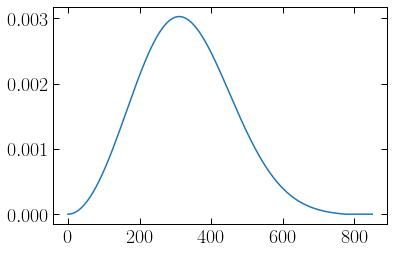

In [5]:
v_list = np.linspace(0, 850, 1000)
plt.figure()

plt.plot(v_list, MB.calcf_SHM(v_list))

plt.show()

Now let's try to calculate the velocity distribution $f(v)$ at one specific value of $v$, let's call it $v_1$:

In [6]:
v1 = 200 #km/s
#f_final = verne.CalcF(v1, gamma=0.0, depth=100, sigma_p=1e-26, m_x=1.0, target="SUF", vmax_interp=None, interaction="SI")

Okay, so the code won't let us use `None` :( So it turns out that `vmax_interp` needs to be some kind of function, which returns the maximum possible final speed at the detector $v_{f,\mathrm{max}}$, as a function of $\theta$, the incoming direction of the DM particle. What happens if we specify something very general?

In [7]:
def vmax_interp1(theta):
    return 800 #km/s

In [8]:
f_final = verne.CalcF(v1, gamma=gamma, depth=depth, sigma_p=sig0, m_x=m_x, target="full", vmax_interp=vmax_interp1, interaction="SI")
print(f_final)

0.00024950740587414126


Hmmm...that seems to work - let's try doing it for a range of velocities:

In [9]:
#v_list = np.linspace(0, 800, 100)
v_list = np.linspace(1e-3, 800, 50)
%time f_final_list = [verne.CalcF(v, gamma=gamma, depth=depth, sigma_p=sig0, m_x=m_x, target="full", vmax_interp=vmax_interp1, interaction="SI") for v in v_list]

/Users/bradkav/opt/miniconda3/envs/igwn-py38/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


CPU times: user 2min, sys: 1.81 s, total: 2min 2s
Wall time: 2min 3s


In [10]:
print(np.trapz(f_final_list, v_list))

20.448701121751245


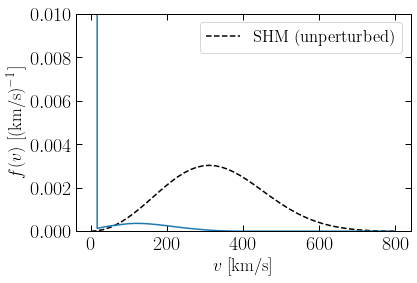

In [11]:
plt.figure()

plt.plot(v_list, MB.calcf_SHM(v_list), 'k--', label='SHM (unperturbed)')
plt.plot(v_list, f_final_list)

plt.xlabel('$v$ [km/s]')
plt.ylabel('$f(v)$ [(km/s)$^{-1}$]')

plt.legend()
plt.ylim(0, 1e-2)
plt.show()

This works, but it's pretty slow. Let's calculate the maximum velocity as a function of the incoming angle $\theta$. We want to do this in advance (rather than letting `verne.CalcF` deal with it internally) because we need this function repeatedly (every time we call `verne.CalcF` for a different `v`, we don't want to have to recalculate!).

The maximum velocity at the detector corresponds to the final velocity of the DM particle which has the largest *initial* velocity. The maximum initial velocity depends on the incoming direction of the DM particle. Let's write $\mathbf{v}_g$ as the velocity of a DM particle in the galactic rest frame, $\mathbf{v}$ as the velocity of that same particle in the Earth's frame and $\mathbf{v}_e$ the velocity of the Earth with respect to the Galaxy. Then:

$$
\begin{align}
\mathbf{v}_g &= \mathbf{v} - \mathbf{v}_e\\
\Rightarrow v_g^2&= v^2 + v_e^2 - 2 \mathbf{v}\cdot \mathbf{v}_e
\end{align}
$$

To find the maximum speed in the Earth frame, we'll set $v_g = v_\mathrm{esc}$, the escape velocity in the Galactic rest frame:
$$
\begin{align}
v^2 - 2 \mathbf{v}\cdot \mathbf{v}_e + v_e^2 - v_\mathrm{esc}^2  = 0
\end{align}
$$

Based on the definitions of the angles $\gamma$ and $\theta$, you can show that the angle $\alpha$ between $\mathbf{v}$ and $\mathbf{v}_e$ is:
$$\cos\alpha = \sin\gamma\,\sin(\pi -\theta) + \cos\gamma\,\cos(\pi - \theta)$$
*(This is actually a nice exercise, to check that you understand what these angles mean).*

We finally have:
$$
\begin{align}
v^2 - 2 v\,v_e\cos\alpha + (v_e^2 - v_\mathrm{esc}^2)  = 0
\end{align}
$$
which can be solved to obtain $v$, the maximum initial velocity as a function of $\gamma$ and $\theta$. 

In [12]:
#Let's calculate over a range of theta values

Nvals = 501
thetavals = np.linspace(0, np.pi, Nvals)

#Loading values from MaxwellBoltzmann module:
v_e = np.sqrt(2.0)*MB.sigmav
vesc = MB.vesc

#Solving using quadratic formula:
a = 1.0
b = 2*v_e*(-np.sin(gamma)*np.sin(np.pi-thetavals) + np.cos(gamma)*np.cos(np.pi-thetavals))
c = v_e**2 - vesc**2
v_initial_max = (-b + np.sqrt(b**2 - 4*a*c))/(2.0*a)

#Now we loop over values of theta, calculating the final velocity at the detector
        #Calculate the maximum final speed as a function of incoming angle theta
v_final_max = 0.0*v_initial_max
for i in range(Nvals):
    v_final_max[i] = verne.calcVfinal_full(v_initial_max[i], thetavals[i],  depth=depth, sigma_p=sig0, m_x=m_x, interaction="SI", target="full")    

#Now generate an interpolation function for v_final(theta):
vmax_interp2 = interp1d(thetavals, 1.05*v_final_max, kind='linear', bounds_error=False, fill_value=0)

/Users/bradkav/opt/miniconda3/envs/igwn-py38/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


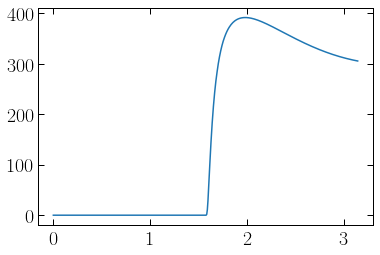

In [13]:
plt.figure()

plt.plot(thetavals, v_final_max)

plt.show()

In [14]:
#This thing works just like any other function:
print(vmax_interp2(0.75*np.pi))

382.08797140712375


**WARNING:** Note here that you should make sure that the parameters you use to calculate this interpolation function (depth, mass, cross section etc) agree with the parameters you'll use to calculate the velocity distribution. Otherwise things won't be consistent. This means you have to recalculate this interpolation function whenever you change e.g. $\gamma$.

It's possible that there's a more refined way of doing all this, but for the moment, this saves the code having to store these things internally...

Now let's try calculating things again, using this more accurate function for v_max(theta):

In [15]:
v_list_i = np.linspace(0, 800, 50)

Nv1 = 20
Nv2 = 30
Nv3 = 48

v_th = 20.0
vmax = np.max(v_final_max)
v_list = np.logspace(np.log10(v_th), np.log10(0.25*vmax), Nv1)    #20                             
v_list = np.append(v_list, np.linspace(0.15*vmax, 0.6*vmax*1.05, Nv2)) #40 
v_list = np.append(v_list, np.linspace(0.61*vmax, 0.999*vmax*1.05, Nv3))
v_list = np.append(v_list, 0.99*v_th)
v_list = np.sort(v_list)

In [16]:
f_final_SI_list = 0.0*v_list
#print(v_list)
for i in tqdm(range(len(v_list))):
    v = v_list[i]
    f_final_SI_list[i] = verne.CalcF(v, gamma=gamma, depth=depth, sigma_p=sig0, m_x=m_x, target="full", vmax_interp=vmax_interp2, interaction="SI")
    #print(f_final_SI_list[i])
#%time f_final_SI_list = [verne.CalcF(v, gamma=gamma, depth=1400, sigma_p=300e-36, m_x=0.5, target="full", vmax_interp=vmax_interp2, interaction="SI") for v in v_list]

100%|██████████| 99/99 [00:50<00:00,  1.97it/s]


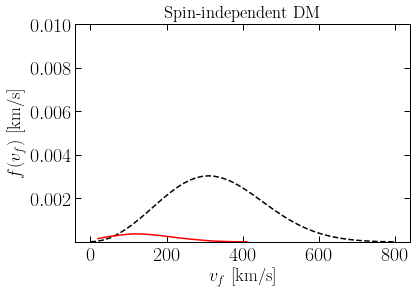

In [17]:
plt.figure()

plt.plot(v_list_i, MB.calcf_SHM(v_list_i), 'k--', label='SHM (unperturbed)')
#plt.plot(v_list, f_final_list, 'b-')
plt.plot(v_list, f_final_SI_list, 'r-')

plt.xlabel(r"$v_f$ [km/s]")
plt.ylabel(r"$f(v_f)$ [km/s]")

plt.title("Spin-independent DM")


plt.ylim(1e-5, 1e-2)
plt.show()

Great! That's now faster, because the code isn't wasting time calculating for speeds which are unphysically large!

### Verne for Light Dark Matter

In [9]:
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import MaxwellBoltzmann as MB
import verne_light

In [10]:
plt.rcParams.update({'font.size': 20})

`verne_light` assumes that the energy loss of DM particles as they scatter is negligible (because of the large kinematic mismatch between keV DM particles and nuclei in the Earth). In this case, then, we don't need to keep track of the evolution of the DM velocity. This means that it's useful to pre-tabulate the density of nuclei along different trajectories. 

This is mandatory, and should be done specifying the depth of the detector (in metres) and the target ("full", "atmos" or "earth"):

In [11]:
verne_light.Tabulate_Column_Density(depth=1400.0, target="full")

100%|██████████| 10001/10001 [00:09<00:00, 1104.35it/s]


Now for light DM interaction via a Dark Photon mediator, we often want to convert between electron and proton scattering cross sections:

In [12]:
m_p = 0.9315 #Proton mass
m_e = 511e3/1e9 #Electron mass

def m_reduced(m1, m2):
    return m1*m2/(m1 + m2)

def sigma_e_to_sigma_p(sigma_e, m_x):
    mu_eX = m_reduced(m_e, m_x)
    mu_pX = m_reduced(m_p, m_x)
    return (mu_pX/mu_eX)**2*sigma_e
    
def sigma_p_to_sigma_e(sigma_p, m_x):
    mu_eX = m_reduced(m_e, m_x)
    mu_pX = m_reduced(m_p, m_x)
    return (mu_eX/mu_pX)**2*sigma_p

We can now calculate the velocity distribution for a given set of parameters:

In [13]:
m_x   = 1e-3 #GeV
sig_e = 1e-32 #cm^2
med = "ulm"
gamma = 0.3

vlist = np.linspace(0, MB.ve + MB.vesc, 101)

sig_p = sigma_e_to_sigma_p(sig_e, m_x)

f_trans = np.zeros(len(vlist))
f_refl = np.zeros(len(vlist))

for i, v in enumerate(tqdm(vlist)):
    #Calculate transmitted and reflected component
    f_trans[i] = verne_light.CalcF_transmitted(v, gamma, sigma_p=sig_p, m_x=m_x, target="full", interaction=med)
    f_refl[i] = verne_light.CalcF_reflected(v, gamma, sigma_p=sig_p, m_x=m_x, target="full", interaction=med)
    
f_full = f_trans + f_refl

100%|██████████| 101/101 [00:07<00:00, 12.75it/s]


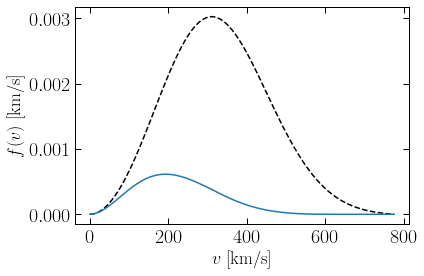

In [15]:
plt.figure()

plt.plot(vlist, MB.calcf_SHM(vlist), color='k', linestyle='--')
plt.plot(vlist, f_full)

plt.xlabel(r"$v$ [km/s]")
plt.ylabel(r"$f(v)$ [km/s]")
plt.show()

The code accepts the following `interaction` types:
- `SI`: Spin-independent (neglecting form factors)
- `hm`: Heavy dark photon mediator (including charge screening)
- `ulm`: Ultra-light dark photon mediator (including charge screening)